# Task 5: Programming Optimization Problem

Program the system and the optimization problem using do-mpc framework. Test your solution. Visualize your results.\
Take into account do-mpc cost function framework:

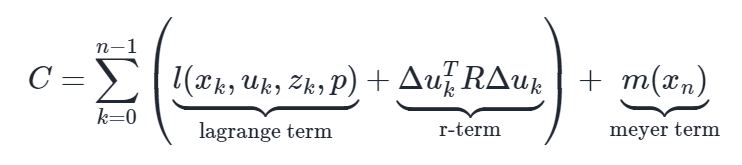

### Step 1. Install do-mpc library and import necessary libraries

In [66]:
# Install do-mpc library
!pip install do-mpc

In [67]:
# Import libraries
import numpy as np
import do_mpc
import casadi
import matplotlib.pyplot as plt
import matplotlib as mpl

### Step 2. Define model parameters

Notice:
1. Ensure that x₀ is represented as a column vector. For NumPy arrays, use the reshape method to achieve this.
2. The simulation time step (dt) is typically smaller than the model’s time step because it needs to accurately represent a real-world environment.
3. The performance of the MPC controller strongly depends on the horizon length, as it defines how far into the future the controller can predict. However, a longer horizon increases the computational cost. Experiment with different horizon lengths to find the optimal balance.

In [68]:
# Parameters
x0 = np.array([0,0,0]).reshape(-1,1)                                # Initial State, [x, y, theta]
dt =  0.1                                # Model step interval, [s]
sim_dt =  0.01                             # Simulator step interval, [s]
horizon =   25                          # Number of receding horizon steps, [#]
goal =  np.array([10,20])                             # Navigation goal, [x, y]
obstacle =  np.array([3,4,3])                        # Obstacle coordinates and radius, [x, y, radius]
safe_distance =    3                   # Minimum distance to obstacle, [m]

### Step 3. Create your system model

In [69]:
# Create your discrete system model
model = do_mpc.model.Model("discrete")

# State variables
pose_x = model.set_variable(var_type='_x', var_name='pose_x')
pose_y = model.set_variable(var_type='_x', var_name='pose_y')
pose_theta = model.set_variable(var_type='_x', var_name='pose_theta')

# Control input variables
u_v = model.set_variable(var_type='_u', var_name='u_v')
u_omega = model.set_variable(var_type='_u', var_name='u_omega')

# Define system equations
model.set_rhs('pose_x', pose_x + u_v * casadi.cos(pose_theta) * dt)
model.set_rhs('pose_y', pose_y + u_v * casadi.sin(pose_theta) * dt)
model.set_rhs('pose_theta', pose_theta + u_omega * dt)

# Setup and obstacle distance function the cost
obstacle_distance = (casadi.sqrt((pose_x - obstacle[0]) ** 2 + (pose_y - obstacle[1]) ** 2) - obstacle[2] - safe_distance)
model.set_expression("obstacle_distance", obstacle_distance)

cost = (casadi.sqrt((pose_x - goal[0])**2 + (pose_y - goal[1])**2))
model.set_expression('cost', cost)

# Setup the model
model.setup()

### Step 4. Create your controller

In [70]:
# Create your controller
mpc = do_mpc.controller.MPC(model)

# Set parameters
setup_mpc = {
            'n_robust': 0,
            'n_horizon': horizon,
            't_step': dt,
            'state_discretization': 'discrete',
            'store_full_solution': True,
            "nlpsol_opts": {"ipopt.print_level": 0,
                            "ipopt.sb": "yes",
                            "print_time": 0}
        }
mpc.set_param(**setup_mpc)

# Define cost-function
mterm = model.aux['cost']  # terminal cost
lterm = model.aux['cost']  # stage cost
mpc.set_objective(mterm, lterm)

# Set constraints for state and control variables
mpc.bounds['lower', '_x', 'pose_theta'] = -np.pi
mpc.bounds['upper', '_x', 'pose_theta'] = np.pi
mpc.bounds['lower', '_u', 'u_v'] = -5
mpc.bounds['upper', '_u', 'u_v'] = 5
mpc.bounds['lower', '_u', 'u_omega'] = -10
mpc.bounds['upper', '_u', 'u_omega'] = 10

# Define rterm (penalty for control input)
mpc.set_rterm(u_v=1e-4)

# Set nonlinear constraints
mpc.set_nl_cons('obstacle', -model.aux['obstacle_distance'], 0)

# Setup controller
mpc.setup()

### Step 5. Setup simulator

In [71]:
# Set simulator
mpc_simulator = do_mpc.simulator.Simulator(model)
mpc_simulator.set_param(t_step=sim_dt)
mpc_simulator.setup()

### Step 6. Run the simulation

In [72]:
mpc.set_initial_guess()
x_graphics_init = x0  # For plotting purposes
for i in range(40):
    u0 = mpc.make_step(x0)
    x0 = mpc_simulator.make_step(u0)

### Step 7. Setup your graphics

In [73]:
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

sim_graphics = do_mpc.graphics.Graphics(mpc_simulator.data)

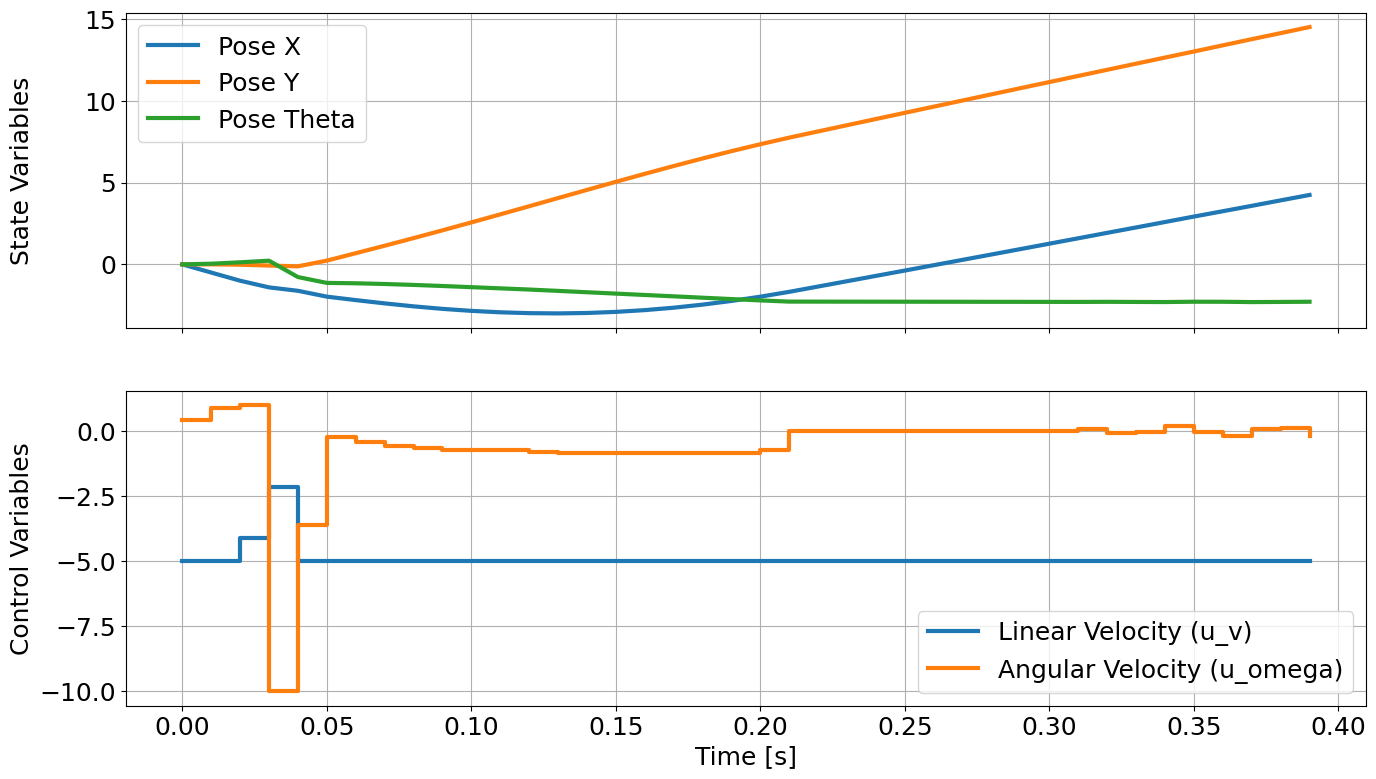

In [74]:
# %%capture
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

for g in [sim_graphics]:
    # Plot the state variables with labels
    g.add_line(var_type='_x', var_name='pose_x', axis=ax[0], label='Pose X')
    g.add_line(var_type='_x', var_name='pose_y', axis=ax[0], label='Pose Y')
    g.add_line(var_type='_x', var_name='pose_theta', axis=ax[0], label='Pose Theta')

    # Plot the control input with labels
    g.add_line(var_type='_u', var_name='u_v', axis=ax[1], label='Linear Velocity (u_v)')
    g.add_line(var_type='_u', var_name='u_omega', axis=ax[1], label='Angular Velocity (u_omega)')

# Set axis labels
ax[0].set_ylabel('State Variables')
ax[1].set_ylabel('Control Variables')
ax[1].set_xlabel('Time [s]')

# Add legends to each axis
ax[0].legend(loc='best')
ax[1].legend(loc='best')


def plot_robot_trajectory(sim_data, goal, obstacle):
    # Extract robot position data
    x = sim_data['_x'][:, 0]  # x coordinate
    y = sim_data['_x'][:, 1]  # y coordinate

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot robot trajectory
    ax.plot(x, y, 'b-', label='Robot Trajectory')

    # Mark start and goal points
    ax.plot(x_graphics_init[0], x_graphics_init[1], 'go', markersize=10, label='Start')
    ax.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')

    # Add obstacle
    obstacle_circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r', fill=False, label='Obstacle')
    ax.add_artist(obstacle_circle)

    # Configure the plot
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Robot Movement Trajectory')
    ax.legend()
    ax.grid(True)

    # Set equal scale for both axes
    ax.set_aspect('equal', 'box')

    # Slightly expand plot boundaries
    # ax.set_xlim(min(x) - 0.5, max(x) + 0.5)
    # ax.set_ylim(min(y) - 0.5, max(y) + 0.5)

    return fig, ax

### Step 8. Plot your results

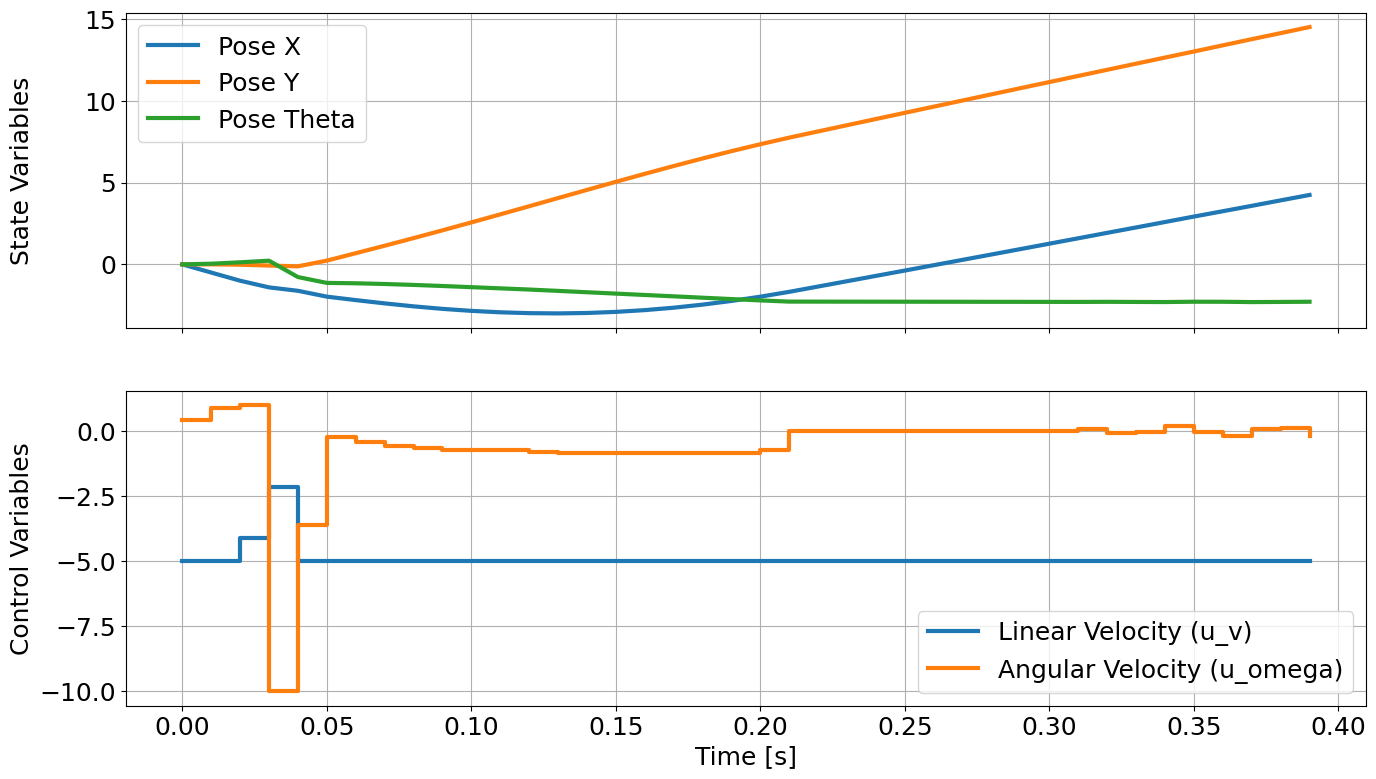

In [75]:
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

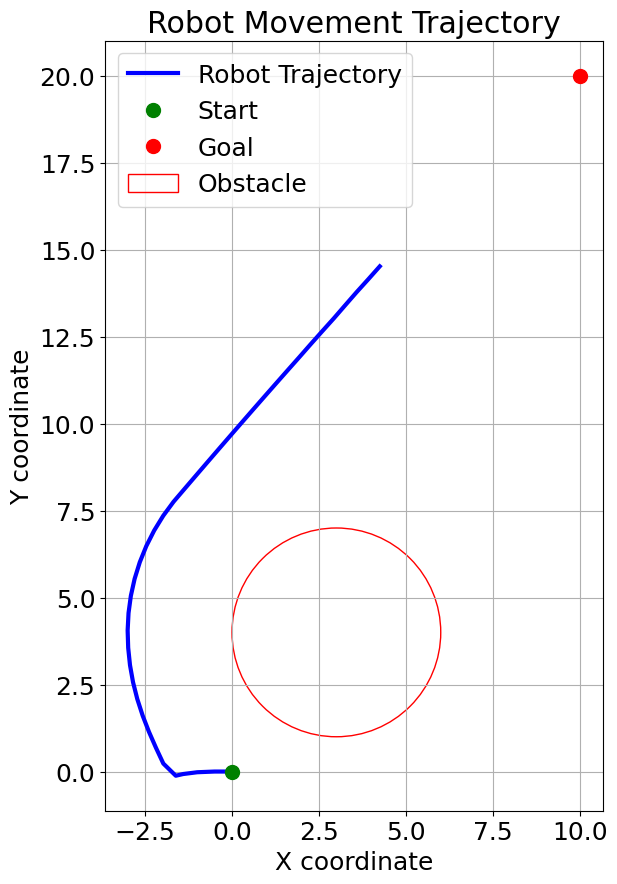

In [76]:
# Usage of the function:
fig, ax = plot_robot_trajectory(mpc_simulator.data, goal, obstacle)
plt.show()